<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plot-neutralization-curves" data-toc-modified-id="Plot-neutralization-curves-1">Plot neutralization curves</a></span><ul class="toc-item"><li><span><a href="#Configuration-and-setup" data-toc-modified-id="Configuration-and-setup-1.1">Configuration and setup</a></span></li><li><span><a href="#Read-neutralization-data" data-toc-modified-id="Read-neutralization-data-1.2">Read neutralization data</a></span></li><li><span><a href="#Fit-and-plot-neutralization-curves" data-toc-modified-id="Fit-and-plot-neutralization-curves-1.3">Fit and plot neutralization curves</a></span></li></ul></li></ul></div>

# Plot neutralization curves

In this notebook we will create neutralization plots from GFP-based neutralization assays. 
The GFP-based neutralization assay system is described in detail in [Bloom et al (2010)](http://science.sciencemag.org/content/328/5983/1272.long) and [Hooper and Bloom (2013)](https://jvi.asm.org/content/87/23/12531).

In brief, we generate by reverse genetics influenza viruses that carry GFP in the PB1 segment. We then quantified using a plate reader the GFP signal produced by MDCK-SIAT1-CMV-PB1 cells infected with PB1flank-eGFP virus that had been incubated with various dilutions of antibody or serum. The neutralization curves represent the mean and standard deviation of three measurements, with each replicate in a separate column of a 96-well plate.

In [1]:
import os
import warnings

from IPython.display import display, HTML

import numpy

import pandas as pd

from plotnine import *

import yaml

import neutcurve
from neutcurve.colorschemes import CBPALETTE
import neutcurve.parse_excel

print(f"Using neutcurve version {neutcurve.__version__}")

Using neutcurve version 0.2.dev0


In [2]:
pd.set_option('display.float_format', '{:.3g}'.format)

In [3]:
# Hide warnings that can clutter output
warnings.simplefilter('ignore')

## Configuration and setup
Read general configuration from [config.yaml](config.yaml):

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read the neutralization assay configuration from the specified file:

In [5]:
print(f"Reading neutralization assay setup from {config['neut_config']}")

with open(config['neut_config']) as f:
    neut_config = yaml.safe_load(f)

Reading neutralization assay setup from data/neut_assays/neut_config.yaml


Get the output directory:

In [6]:
outdir = config['neutresultsdir']
os.makedirs(outdir, exist_ok=True)
print(f"Output will be written to {outdir}")

Output will be written to results/neutralization_assays


## Read neutralization data

Next, for each dict in _neut_config_, we use `neutcurve.parse_excel.parseRachelStyle2019` to create a tidy data frame appropriate for passing to `neutcurve.CurveFits`. We then concatenate all the tidy data frames to get our neutralization data:

In [7]:
neutdata = []  # store all data frame, then concatenate at end

for sampledict in neut_config:
    assert len(sampledict) == 1
    sampleset, kwargs = list(sampledict.items())[0]
    print(f"Parsing data for {sampleset}...")
    neutdata.append(neutcurve.parse_excel.parseRachelStyle2019(**kwargs))

neutdata = pd.concat(neutdata)
print(f"Read data for {len(neutdata.groupby('serum'))} sera and "
      f"{len(neutdata.groupby(['serum', 'virus']))} serum / virus pairs.")

Parsing data for VIDD1...
Parsing data for VIDD2...
Parsing data for VIDD3...
Parsing data for VIDD4...
Parsing data for VIDD5...
Parsing data for 557v1...
Parsing data for 557v2...
Parsing data for 574v1...
Parsing data for 574v2...
Parsing data for 589v1...
Parsing data for 589v2...
Parsing data for 571v1...
Parsing data for 571v2...
Parsing data for ferret-Pitt-1-preinf...
Parsing data for ferret-Pitt-1-postinf...
Parsing data for ferret-Pitt-2-preinf...
Parsing data for ferret-Pitt-2-postinf...
Parsing data for ferret-Pitt-3-preinf...
Parsing data for ferret-Pitt-3-postinf...
Parsing data for ferret-WHO...
Parsing data for ferret-WHO-Victoria2011...
Parsing data for antibody-5A01...
Parsing data for antibody-3C06...
Parsing data for antibody-3C04...
Parsing data for antibody-4C01...
Parsing data for antibody-4F03...
Parsing data for antibody-1C04...
Read data for 27 sera and 91 serum / virus pairs.


Write the neutralization data to a CSV file in our output directory:

In [8]:
neutdatafile = os.path.join(outdir, 'neutdata.csv')
neutdata.to_csv(neutdatafile, index=False)
print(f"Wrote neutralization data to {neutdatafile}")

Wrote neutralization data to results/neutralization_assays/neutdata.csv


## Fit and plot neutralization curves

Now we fit the neutralization curves with a neutcurve.CurveFits:

In [9]:
fits = neutcurve.CurveFits(neutdata)

Make plots for each serum sample:

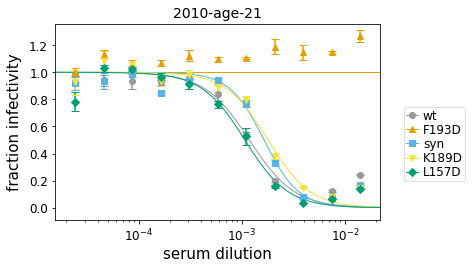

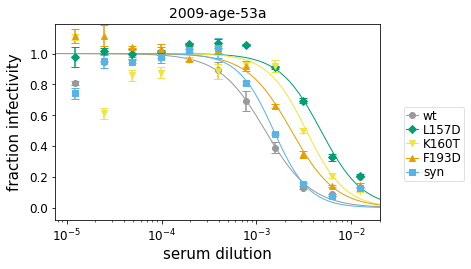

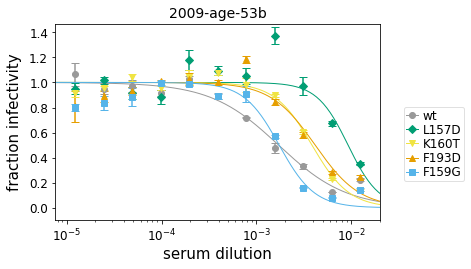

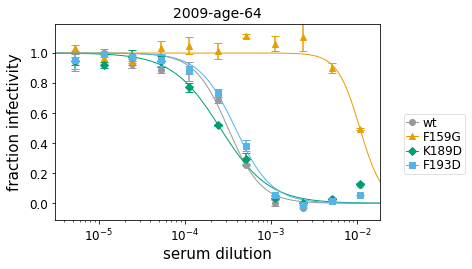

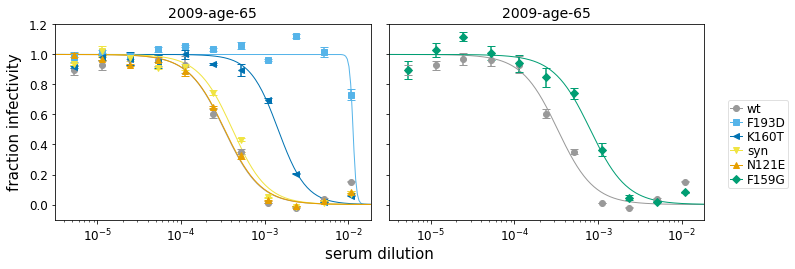

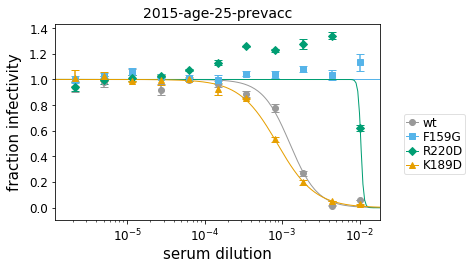

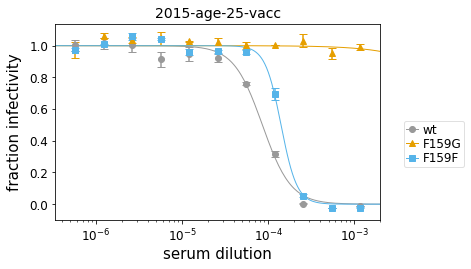

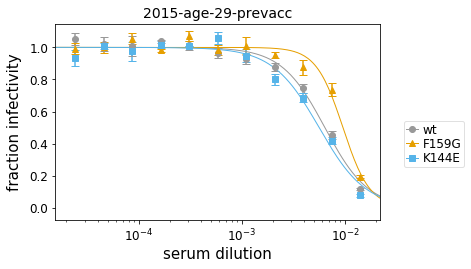

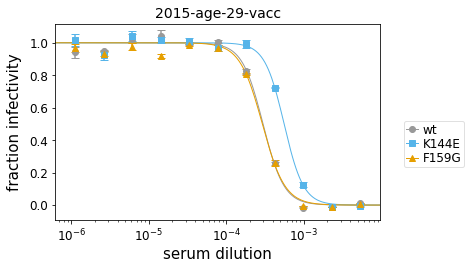

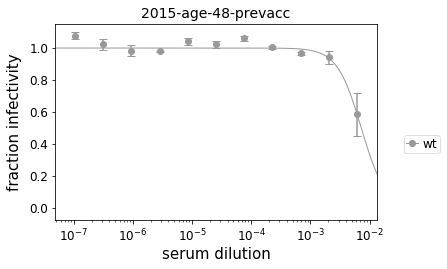

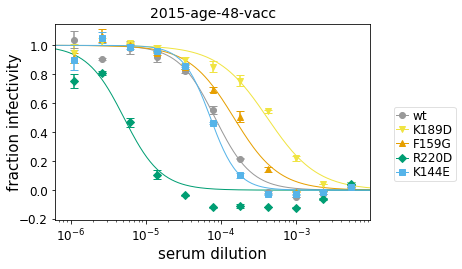

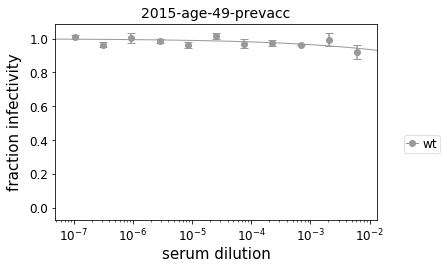

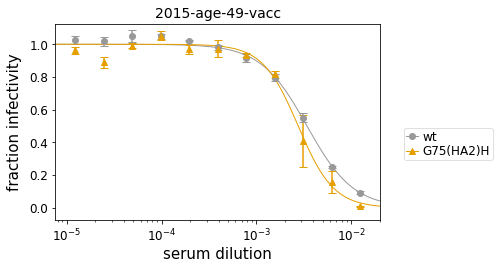

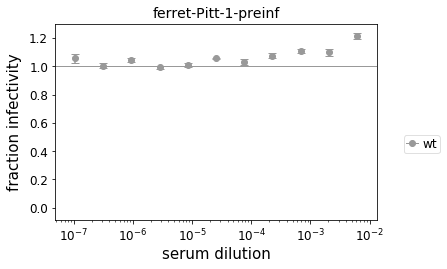

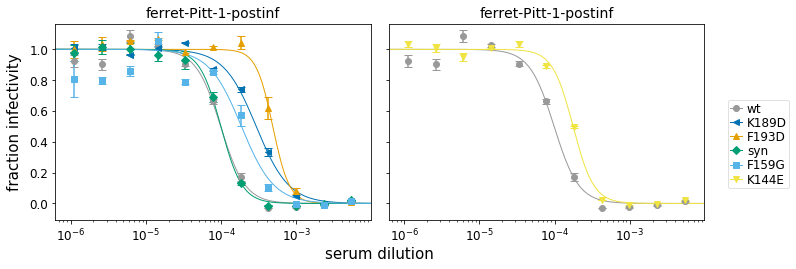

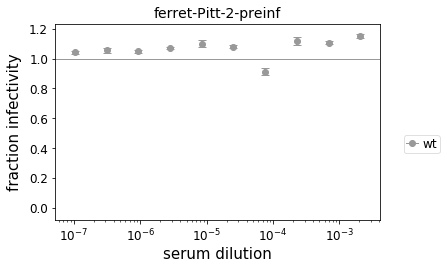

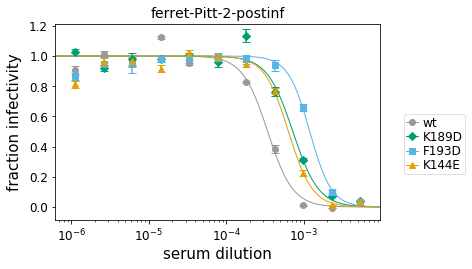

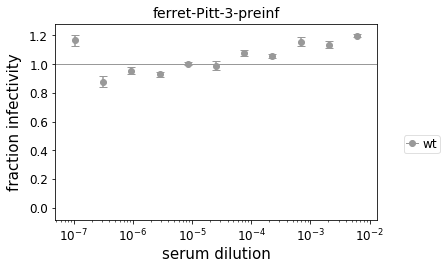

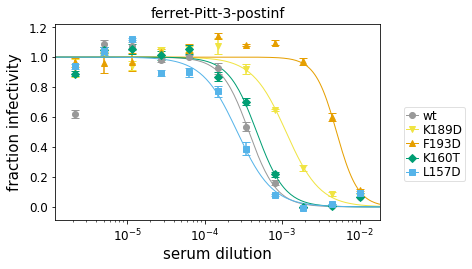

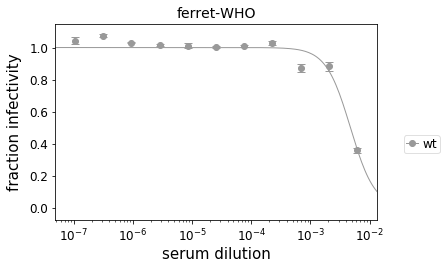

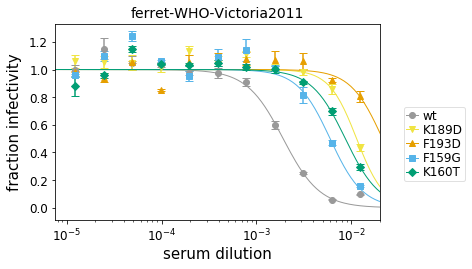

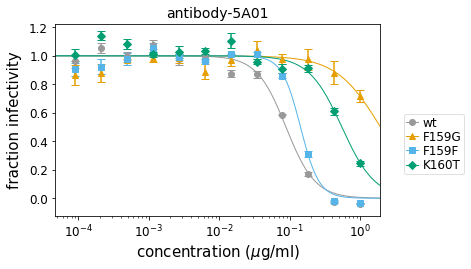

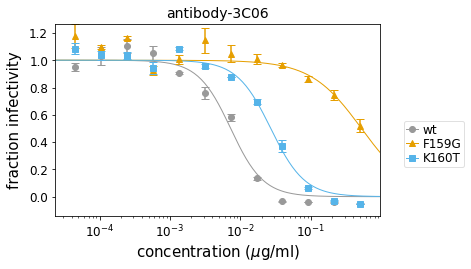

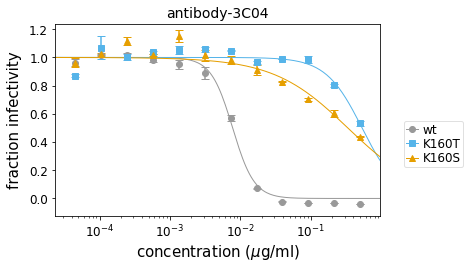

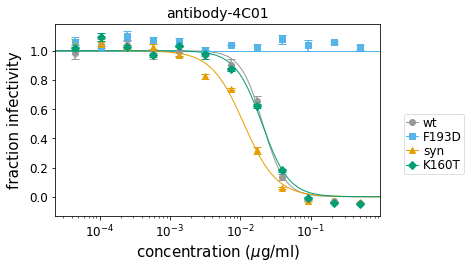

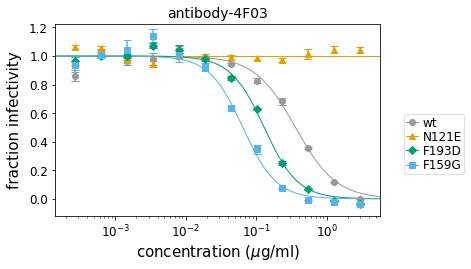

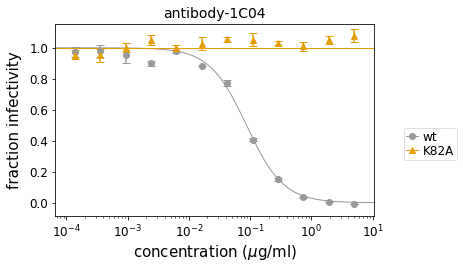

In [10]:
for s in neutdata['serum'].unique():
    if 'antibody' not in s:
        fig, axes = fits.plotSera(sera=[s], 
                                  xlabel='serum dilution', 
                                  widthscale=1.5, 
                                  heightscale=1.3)
    else:
        fig, axes = fits.plotSera(sera=[s], 
                                  xlabel='concentration ($\mu$g/ml)', 
                                  widthscale=1.5, 
                                  heightscale=1.3)

In [11]:
fitparams = fits.fitParams()

In [12]:
display(HTML(fitparams.to_html(index=False)))

serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
2010-age-21,wt,average,3,0.00118,interpolated,0.00118,0.00118,1.99,1,0
2010-age-21,F193D,average,3,0.014,lower,>0.014,0.44,6.99,1,0
2010-age-21,syn,average,3,0.00164,interpolated,0.00164,0.00164,2.59,1,0
2010-age-21,K189D,average,3,0.0018,interpolated,0.0018,0.0018,2.13,1,0
2010-age-21,L157D,average,3,0.00107,interpolated,0.00107,0.00107,2.08,1,0
2009-age-53a,wt,average,3,0.00124,interpolated,0.00124,0.00124,1.78,1,0
2009-age-53a,L157D,average,3,0.00481,interpolated,0.00481,0.00481,1.98,1,0
2009-age-53a,K160T,average,3,0.00338,interpolated,0.00338,0.00338,2.12,1,0
2009-age-53a,F193D,average,3,0.00234,interpolated,0.00234,0.00234,1.86,1,0
2009-age-53a,syn,average,3,0.00153,interpolated,0.00153,0.00153,2.32,1,0
